In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch

from seisfwi.model import ElasticModel, ElasticModelRBF
from seisfwi.survey import Survey, Source, Receiver, GenericCable, SeismicData
from seisfwi.propagator import ElasticPropagator
from seisfwi.problem import ElasticFWI, WaveformL2Loss
from seisfwi.utils import wavelet, smooth2d, load_misfit, plot_misfit, gmsh_center2d, set_sigma, RBF

### Elastic Earth Model

In [3]:
def plot_2d(x, z, d, centers = None):

    if type(d) is list:
        plt.figure(figsize=(15, 6))

        for i, dd in enumerate(d):
            plt.subplot(1, len(d), i+1)
            plt.imshow(dd, extent=[x[0]/1000, x[-1]/1000, z[-1]/1000, z[0]/1000],aspect='equal')
            plt.grid()
            plt.colorbar(orientation='horizontal')
            plt.xlabel("Distance (km)")
            plt.ylabel("Depth (km)")
        
    else:
        plt.figure(figsize=(6, 6))
        plt.imshow(d, extent=[x[0]/1000, x[-1]/1000, z[-1]/1000, z[0]/1000], aspect='equal')
        if centers is not None:
            plt.scatter(centers[:,0]/1000, centers[:,1]/1000, marker='.', color = 'r')
        plt.grid()
        plt.colorbar(orientation='horizontal')
        plt.xlabel("Distance (km)")
        plt.ylabel("Depth (km)")
    
    plt.tight_layout()
    plt.show()

def inversion(operator, dobs, niter = 20):

    # observed data
    dobs = torch.tensor(dobs.flatten(), dtype=torch.float32)
    
    # optimizer
    optimizer = torch.optim.LBFGS(operator.parameters(), line_search_fn='strong_wolfe')
    
    misfits = []  # List to store the misfit values
    def closure():
        optimizer.zero_grad()
        dsyn = operator()
        loss = torch.nn.MSELoss()(dsyn, dobs)
        loss.backward()
        misfits.append(loss.item())  # Record the misfit
    
        return loss
    
    # Run the optimization
    for i in range(niter):
        loss = optimizer.step(closure)
        
        # if i%5 == 0:
        print(f"Iteration: {i + 1}/{niter}, misfit: {loss.item(): .2e}")

    # finial data 
    dsyn = operator()
    dsyn = dsyn.detach().numpy()

    return dsyn, np.array(misfits)


In [4]:
nx, nz = 201, 151
dx, dz = 10, 10
ox, oz = 0.0, 0.0
x = np.arange(nx) * dx
z = np.arange(nz) * dz

X, Z = np.meshgrid(x, z)
grid_2d = np.vstack((X.flatten(), Z.flatten())).T

In [5]:
# Select the part of the model
x0, z0 = 5400, 3000
nx1 = int(x0/dx)
nx2 = nx1 + nx * 3
nz1 = int(z0/dx)
nz2 = nz1 + nz * 3

vp_bl = np.load('../Proposal-part2-Why/model/SEAM-Monitor-Vp-01-3122-1250-4.0m.npy')[nx1:nx2,nz1:nz2][::3, ::3].T
vs  = np.zeros_like(vp_bl)
rho = np.ones_like(vp_bl) * 3000

In [6]:
x = np.arange(nx) * dx
z = np.arange(nz) * dz
x_center = 100
z_center = 130
x0, z0 = x[x_center], z[z_center]  # center of the anomaly
sigma_x, sigma_z = 200.0, 400.0  # spreads in x and z directions
X, Z = np.meshgrid(x, z)
f = -50 * np.exp(-((X - x0)**2 / (2 * sigma_x**2) + (Z - z0)**2 / (2 * sigma_z**2)))
f[z_center:, :] = 0.0
# f[:, :x_center-30] = 0.0
# f[:, x_center+30:] = 0.0

In [7]:
## Old changes
# vp_change = np.zeros_like(vp_bl)
# vp_change[40:60,70:130] -= 50
# vp_change = smooth2d(vp_change, 10, 10)
# vp_change[80:85,70:130] += 100

vp_change = np.zeros_like(vp_bl)
vp_change[130:135,70:130] += 100
vp_change += f
vp_ml = vp_bl + vp_change


# # water
# vp0[:20,:] = 1500.0
# vp[:20,:] = 1500.0

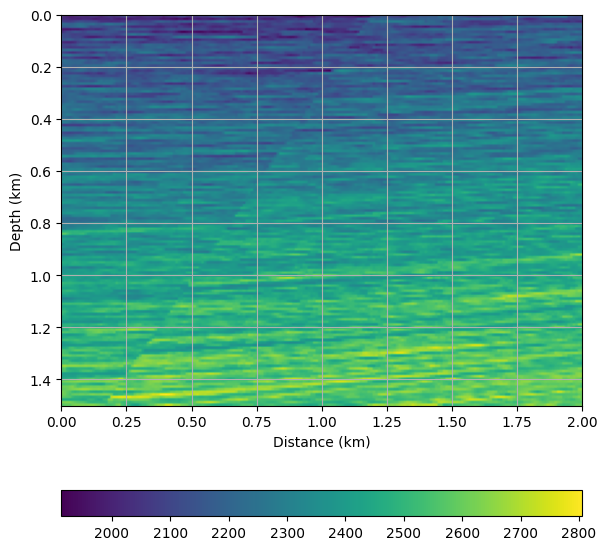

In [8]:
plot_2d(x, z, vp_bl)

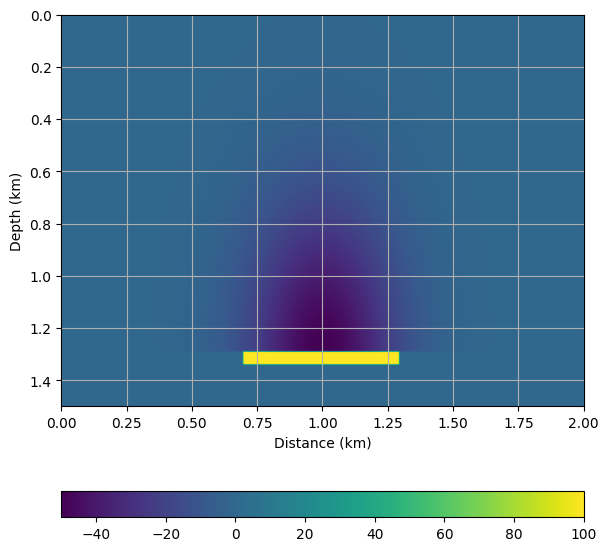

In [9]:
plot_2d(x, z, vp_ml - vp_bl)

In [10]:
density = np.ones((nz, nx), dtype=np.float32)
density[125:140, 50:150] = 2 
density = smooth2d(density, 3, 3)

In [11]:
# Define mesh size bounds
# mesh_min = 20
# mesh_max = 45

# working one!
# mesh_min = 20
# mesh_max = 60

mesh_min = 15
mesh_max = 55

centers_2d, mesh_sizes = gmsh_center2d(density.T, mesh_min, mesh_max, dx)

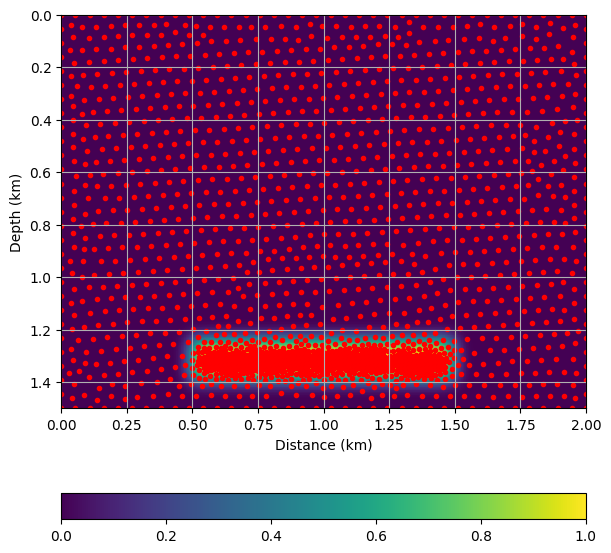

In [12]:
plot_2d(x, z, density, centers_2d)

## Test RBF

In [13]:
# initial theta
theta_2d = np.zeros(centers_2d.shape[0])

# sigma (don't update)
sigma_2d = set_sigma(centers_2d, 1.0)

# Define the RBF centers and create an RBF instance
rbf_2d = RBF(grid_2d, centers_2d, theta_2d, sigma=sigma_2d, update_theta = True, sigma_update = False, rbf_type='gaussian',)

# Invert for changes
vel_2d = vp_ml - vp_bl

In [14]:
vel_2d_inv, misfit_2d = inversion(rbf_2d, vel_2d, niter = 10)
vel_2d_inv = vel_2d_inv.reshape((nz, nx))

Iteration: 1/10, misfit:  2.01e+02
Iteration: 2/10, misfit:  7.24e+00
Iteration: 3/10, misfit:  4.69e+00
Iteration: 4/10, misfit:  4.18e+00
Iteration: 5/10, misfit:  4.01e+00
Iteration: 6/10, misfit:  3.97e+00
Iteration: 7/10, misfit:  3.95e+00
Iteration: 8/10, misfit:  3.93e+00
Iteration: 9/10, misfit:  3.93e+00
Iteration: 10/10, misfit:  3.92e+00


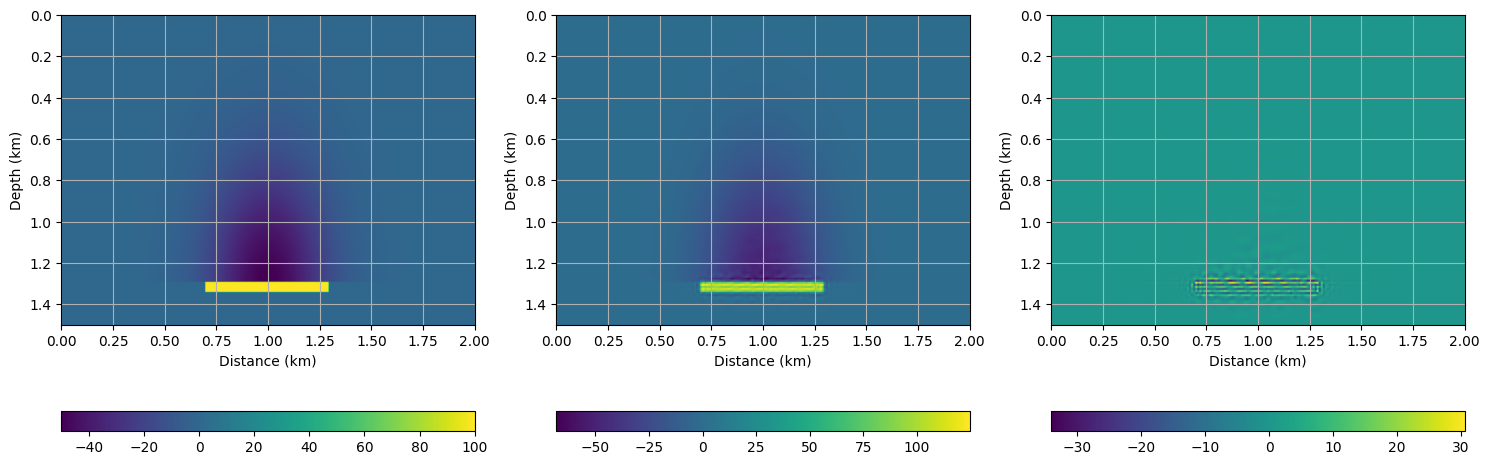

In [15]:
plot_2d(x, z, [vel_2d, vel_2d_inv, vel_2d-vel_2d_inv])

In [16]:
(nx*nz)/centers_2d.shape[0]

17.11844331641286

### From the above test, the center of RBF is legitimate. Move to FWI

In [17]:
nt = 1800
dt = 0.001
f0 = 16
amp = 1e7

In [18]:
model_bl = ElasticModel(ox, oz, dx, dz, nx, nz, vp = vp_bl, vs = vs, rho = rho, free_surface=False, nabc=20)
model_ml = ElasticModel(ox, oz, dx, dz, nx, nz, vp = vp_ml, vs = vs, rho = rho, free_surface=False, nabc=20)

model_ml

Elastic model with parameters ['vp', 'vs', 'rho']:
  Model vp  :  1913.43 -  2865.49 m/s   , requires_grad = False, constrain bound: None - None
  Model vs  :     0.00 -     0.00 m/s   , requires_grad = False, constrain bound: None - None
  Model rho :  3000.00 -  3000.00 kg/m^3, requires_grad = False, constrain bound: None - None
  Model orig: ox =   0.00, oz =   0.00 m
  Model grid: dx =  10.00, dz =  10.00 m
  Model dims: nx =    201, nz =    151
  Model size: 91053
  Free surface: False
  Absorbing layers: 20

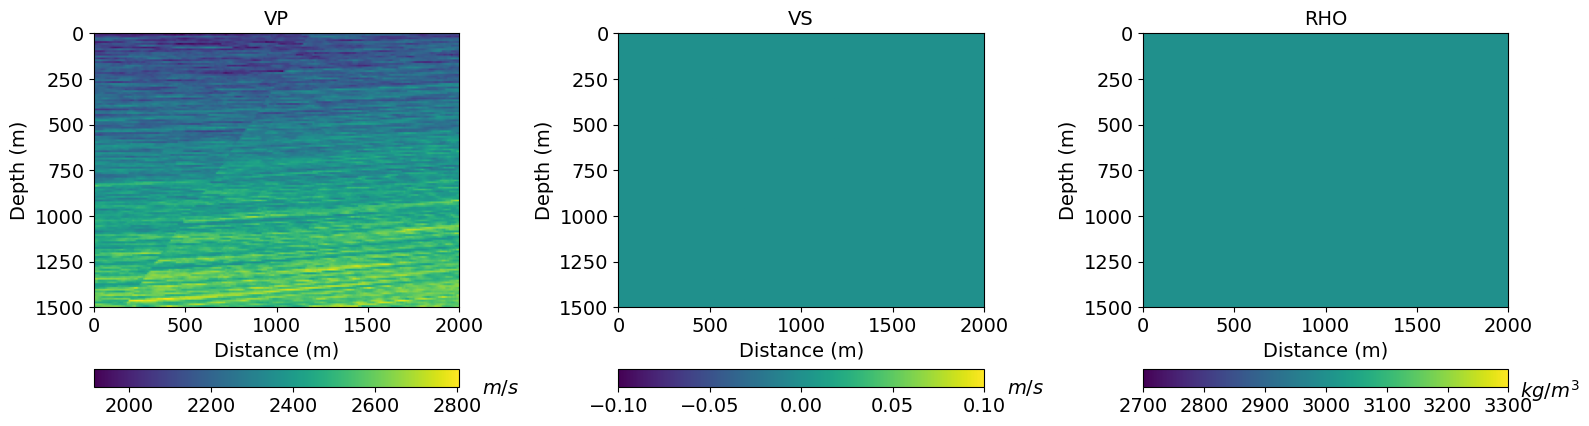

In [19]:
model_bl.plot(orientation='horizontal', cmap = 'viridis')

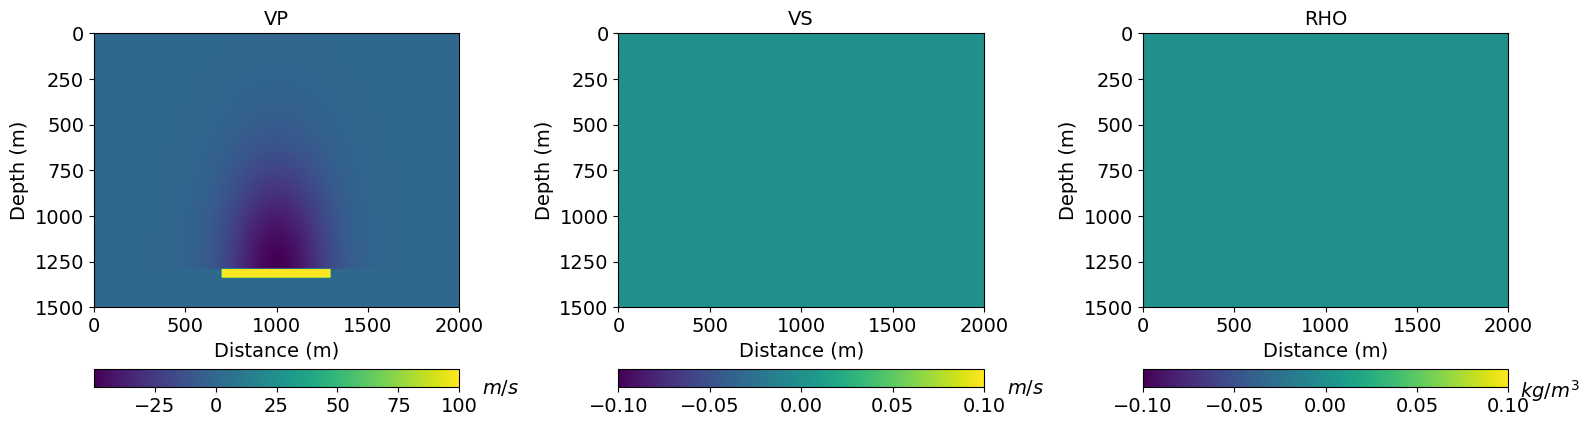

In [20]:
(model_ml - model_bl).plot(orientation='horizontal', cmap = 'viridis')

### Seismic Source 

In [21]:
# Create a seismic sources
source = Source(nt = nt, dt = dt, f0 = f0)

# Create wavelet
wvlt = wavelet(nt, dt, f0) * amp

for i in range(11):
    source.add_source([100 + i*180, dx], wvlt, 'pr')

### Receiver

In [22]:
# Create a set of seismic receiver
geophone = Receiver(nt = nt, dt = dt)

for irec in range(nx-2):
    geophone.add_receiver([dx * (irec + 1), dx], 'vx')
    geophone.add_receiver([dx * (irec + 1), dx], 'vz')

geophone

Seismic Receiver:
  Receiver data   : 1800 samples at 1.00 ms
  Receiver number : 398
  Receiver types  : ['vx', 'vz']
  Receiver x range:  10.00 - 1990.00 m
  Receiver z range:  10.00 -  10.00 m

### Survey

In [23]:
survey = Survey(source=source, receiver=geophone, device='cuda', gpu_num=4)

survey

Survey Information:
  Device   : cuda
  GPU num  : 4
  Apply reciprocity: False
  Simultaneous source: False
  Apply interpolation: False

Seismic Source:
  Source wavelet: 1800 samples at 1.00 ms
  Source number : 11
  Source types  : ['pr']
  Source x range: 100.00 - 1900.00 m
  Source z range:  10.00 -  10.00 m

Seismic Receiver:
  Receiver data   : 1800 samples at 1.00 ms
  Receiver number : 398
  Receiver types  : ['vx', 'vz']
  Receiver x range:  10.00 - 1990.00 m
  Receiver z range:  10.00 -  10.00 m


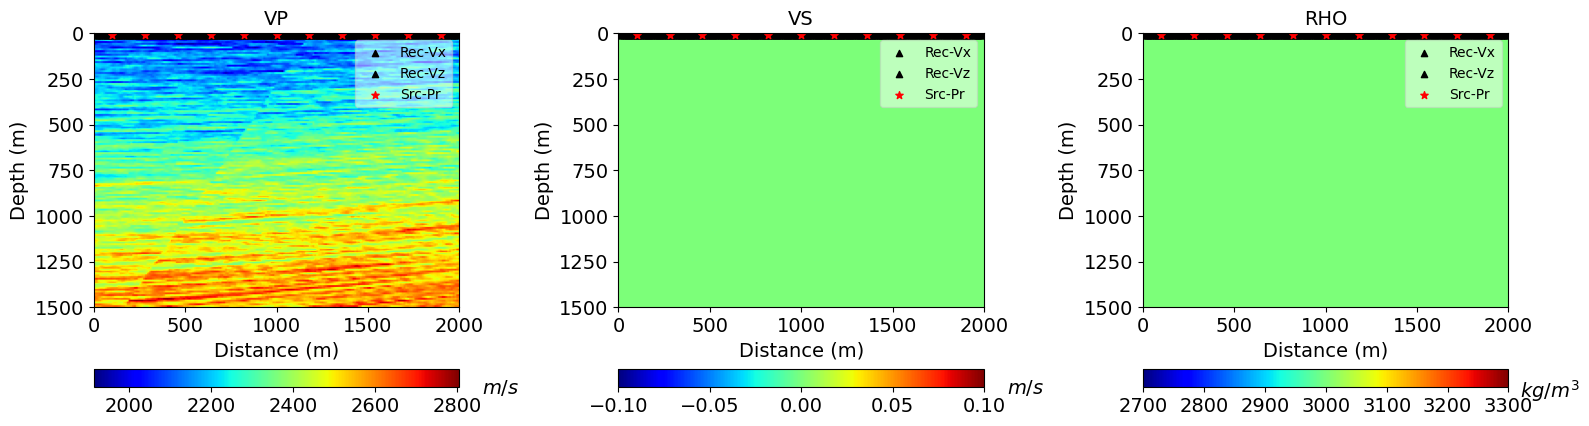

In [24]:
model_bl.plot(survey=survey, orientation='horizontal')

### Elastic Propagator

In [25]:
F = ElasticPropagator(model_bl, survey)

Survey analysis completed: legal survey
free surface: False


### Model the observed data

In [26]:
dobs_bl = F(model_bl)
dobs_ml = F(model_ml)

/sep/haipeng/miniconda3/envs/pytorch/lib/python3.9/site-packages/deepwave/common.py:399: UserWarning: At least six grid cells per wavelength is recommended, but at a frequency of 16, a minimum velocity of 0.0, and a grid cell spacing of 10.0, there are only 0.0.
  warnings.warn("At least six grid cells per wavelength is "


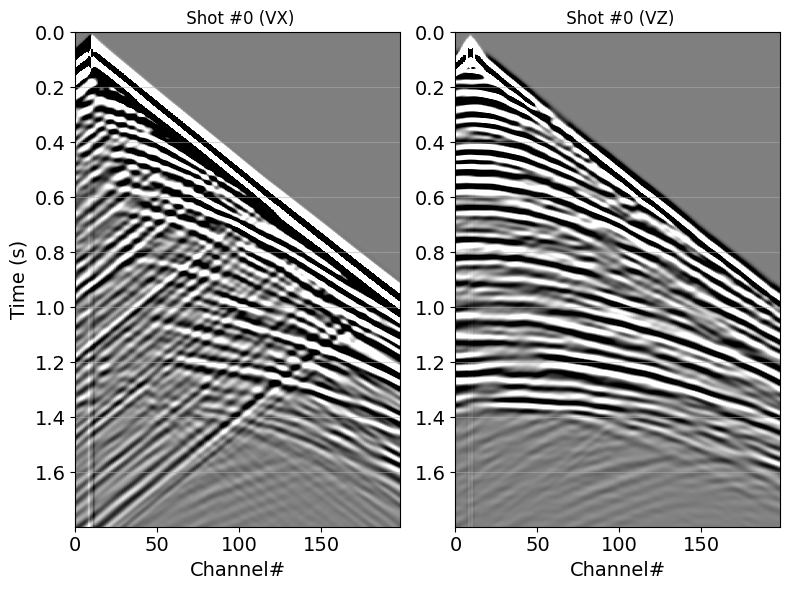

In [27]:
dobs_bl.plot(clip=90, comp={'vx', 'vz'})

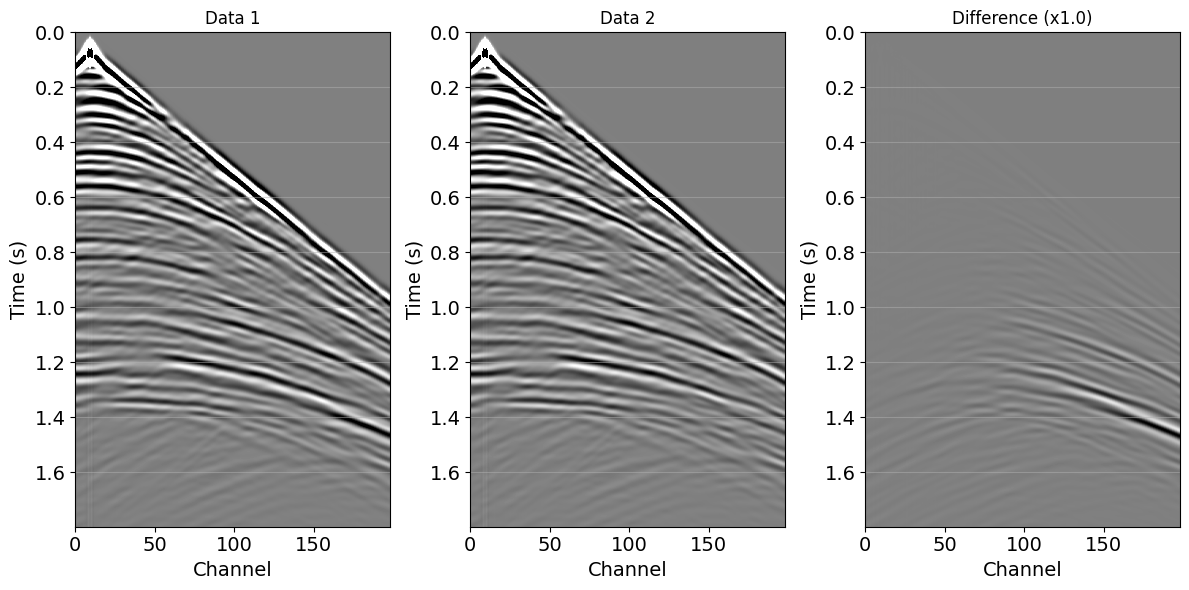

In [28]:
dobs_ml.plot_compare(dobs_bl, clip=98)

## Baseline FWI

In [29]:
grad_mask = np.ones((nz, nx))
grad_mask[:5,:] = 0.0
# grad_mask[10:20, :] = np.repeat(np.linspace(0, 1, 10), nx).reshape(10, nx)
grad_mask = smooth2d(grad_mask, 3, 3)

In [30]:
vp_init = smooth2d(vp_bl, 3, 3)

In [31]:
model_init = ElasticModel(ox, oz, dx, dz, nx, nz, 
                                  vp = vp_init, 
                                  vs = vs, 
                                  rho = rho, 
                                  vp_bound = [1400, 5000],
                                  vp_grad=True,
                                  free_surface=False, nabc=20,
                                  mask = grad_mask)

In [32]:
model_init

Elastic model with parameters ['vp', 'vs', 'rho']:
  Model vp  :  2053.60 -  2612.54 m/s   , requires_grad = True, constrain bound: 1400 - 5000
  Model vs  :     0.00 -     0.00 m/s   , requires_grad = False, constrain bound: None - None
  Model rho :  3000.00 -  3000.00 kg/m^3, requires_grad = False, constrain bound: None - None
  Model orig: ox =   0.00, oz =   0.00 m
  Model grid: dx =  10.00, dz =  10.00 m
  Model dims: nx =    201, nz =    151
  Model size: 91053
  Free surface: False
  Absorbing layers: 20

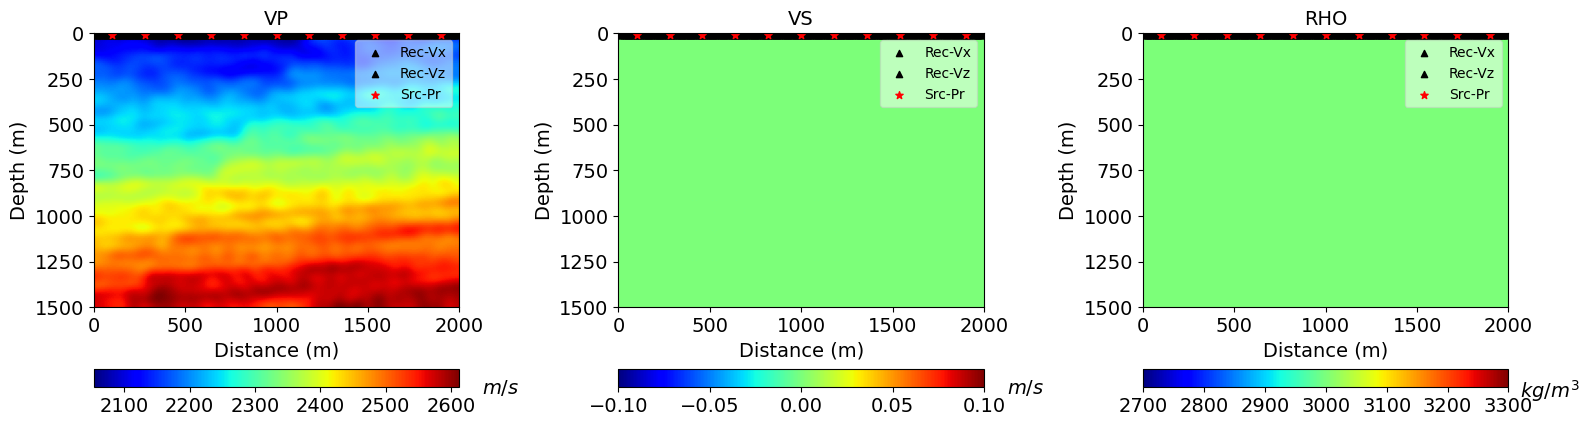

In [33]:
model_init.plot(survey, orientation='horizontal')

In [34]:
# Setup optimizer
optimizer = torch.optim.LBFGS(model_init.parameters(), 
              lr = 1.0,
              max_iter = 70,
              tolerance_change = 1e-4, 
              history_size = 5,
              line_search_fn = 'strong_wolfe')

# Setup misfit function
misfit = torch.nn.MSELoss()

# Setup components
weight = {'vx': 1.0, 'vz': 1.0}
# weight = {'pr': 1.0}

In [35]:
fwi = ElasticFWI(F, model_init, optimizer, misfit, dobs_bl, weight)

In [36]:
fwi(nshot_per_gpu_per_batch = 5, max_iter = 3, grad_scale = 20.0, grad_interval = 4, log_file = 'fwi-acoustic-baseline-SEAM.log')

**********************************************************
            PyTorch l-BFGS Optimizer                
***********************************************************
     Convergence criterion  :   1.00e-04
     Max iteration          :         70
***********************************************************

   Niter           fk                ngrad          max grad
     1       1.426188e+04                1         1.00e+00
     1       1.426184e+04                1         1.00e+00
     1       1.426183e+04                1         1.00e+00
     1       1.426183e+04                1         1.00e+00
     1       1.426183e+04                1         1.00e+00
     1       1.426183e+04                1         1.00e+00
     1       1.426183e+04                1         1.00e+00
     2       3.574651e+03                8         9.03e-02
     3       3.039955e+03                9         8.37e-02
     4       2.209519e+03               10         5.00e-02
     5       1.837762e+0

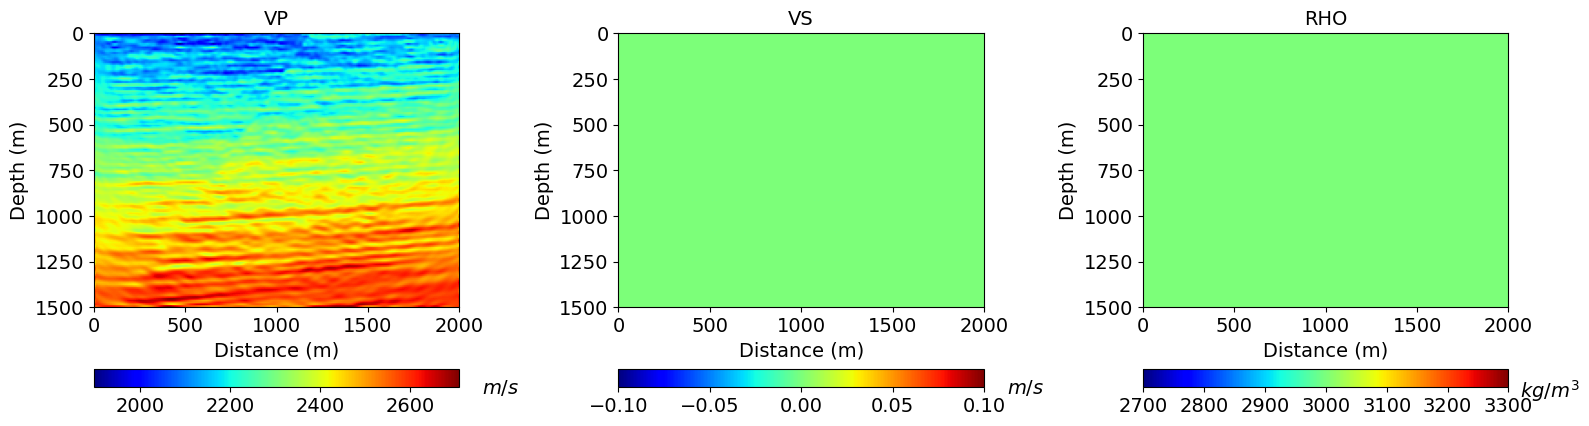

In [37]:
model_init.plot(orientation='horizontal')

In [38]:
model_fwi_bl = ElasticModel(ox, oz, dx, dz, nx, nz, vp = model_init.get_model('vp'), vs = model_init.get_model('vs'), rho = model_init.get_model('rho'), free_surface=False, nabc=20)

# model the syn data of the baseline model
dsyn_bl = F(model_fwi_bl)

In [39]:
dobs_ml.data['vx'] = dobs_ml.data['vx'] - dobs_bl.data['vx'] + dsyn_bl.data['vx']
dobs_ml.data['vz'] = dobs_ml.data['vz'] - dobs_bl.data['vz'] + dsyn_bl.data['vz']

### Set initial model

In [40]:
vp_ml_init = model_init.get_model('vp')
# vp_ml_init = vp_bl

## FWI with Conventional Parameterization with FD Grid

In [41]:
model_init_fd = ElasticModel(ox, oz, dx, dz, nx, nz, 
                                  vp = vp_ml_init, 
                                  vs = vs, 
                                  rho = rho, 
                                  vp_bound = [1400, 5000],
                                  vp_grad=True,
                                  free_surface=False, nabc=20,
                                  mask = grad_mask)

In [42]:
model_init_fd

Elastic model with parameters ['vp', 'vs', 'rho']:
  Model vp  :  1897.21 -  2709.07 m/s   , requires_grad = True, constrain bound: 1400 - 5000
  Model vs  :     0.00 -     0.00 m/s   , requires_grad = False, constrain bound: None - None
  Model rho :  3000.00 -  3000.00 kg/m^3, requires_grad = False, constrain bound: None - None
  Model orig: ox =   0.00, oz =   0.00 m
  Model grid: dx =  10.00, dz =  10.00 m
  Model dims: nx =    201, nz =    151
  Model size: 91053
  Free surface: False
  Absorbing layers: 20

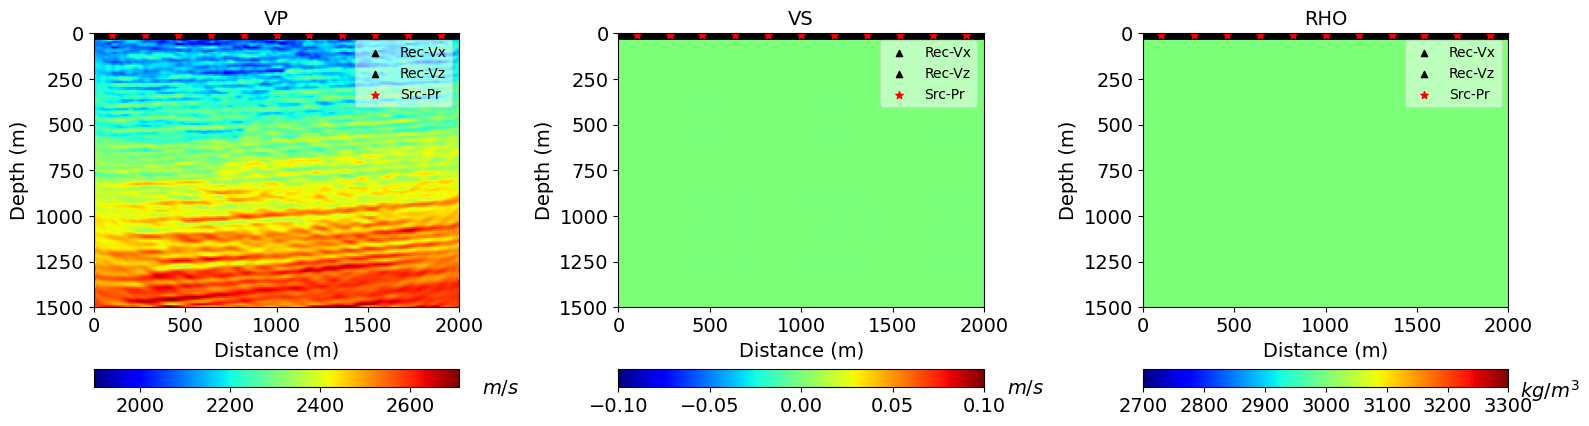

In [43]:
model_init_fd.plot(survey, orientation='horizontal')

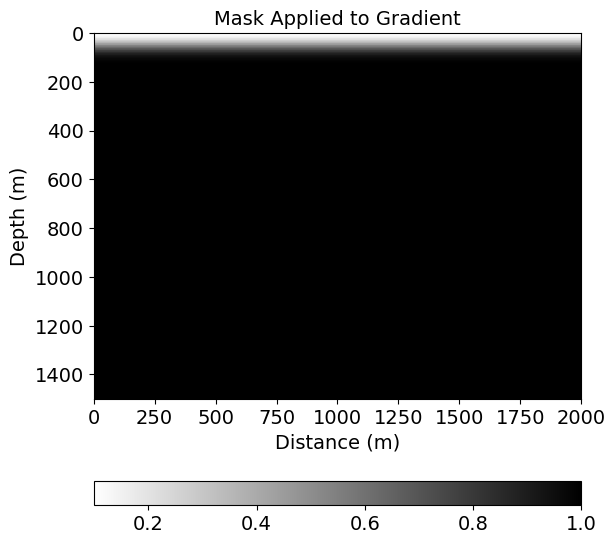

In [44]:
model_init_fd.plot_mask()

### Set optimizer and misfit functional for inversion

In [45]:
# Setup optimizer
optimizer = torch.optim.LBFGS(model_init_fd.parameters(), 
              lr = 1.0,
              max_iter = 50,
              tolerance_change = 1e-4, 
              history_size = 5,
              line_search_fn = 'strong_wolfe')

# Setup misfit function
misfit = torch.nn.MSELoss()

# Setup components
weight = {'vx': 1.0, 'vz': 1.0}
# weight = {'pr': 1.0}

In [46]:
fwi = ElasticFWI(F, model_init_fd, optimizer, misfit, dobs_ml, weight)

In [47]:
fwi(nshot_per_gpu_per_batch = 5, max_iter = 3, grad_scale = 20.0, grad_interval = 4, log_file = 'fwi-acoustic-fd-SEAM.log')

**********************************************************
            PyTorch l-BFGS Optimizer                
***********************************************************
     Convergence criterion  :   1.00e-04
     Max iteration          :         50
***********************************************************

   Niter           fk                ngrad          max grad
     1       1.606201e+04                1         9.99e-01
     1       1.605896e+04                1         9.99e-01
     1       1.606166e+04                1         9.99e-01
     1       1.605896e+04                1         9.99e-01
     1       1.605896e+04                1         9.99e-01
     2       1.539044e+04                6         2.46e+00
     3       1.325369e+04                7         8.25e-01
     4       9.371752e+03                8         1.09e+01
     5       2.714323e+04                9         7.18e+00
     5       9.015843e+03                9         7.87e+00
     5       8.444808e+0

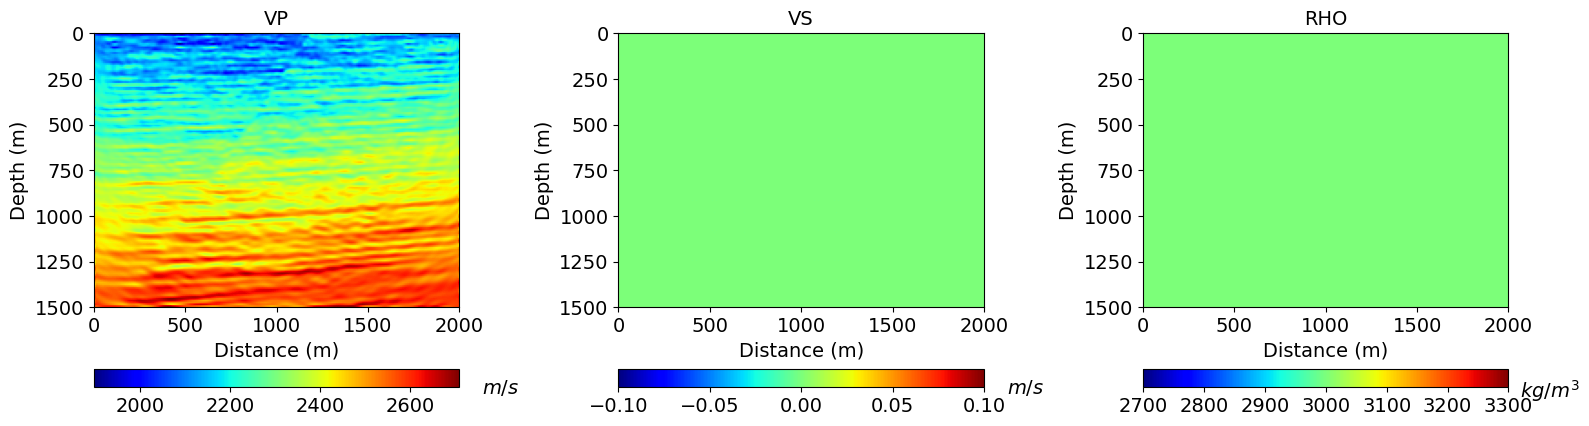

In [48]:
model_init_fd.plot(orientation='horizontal')

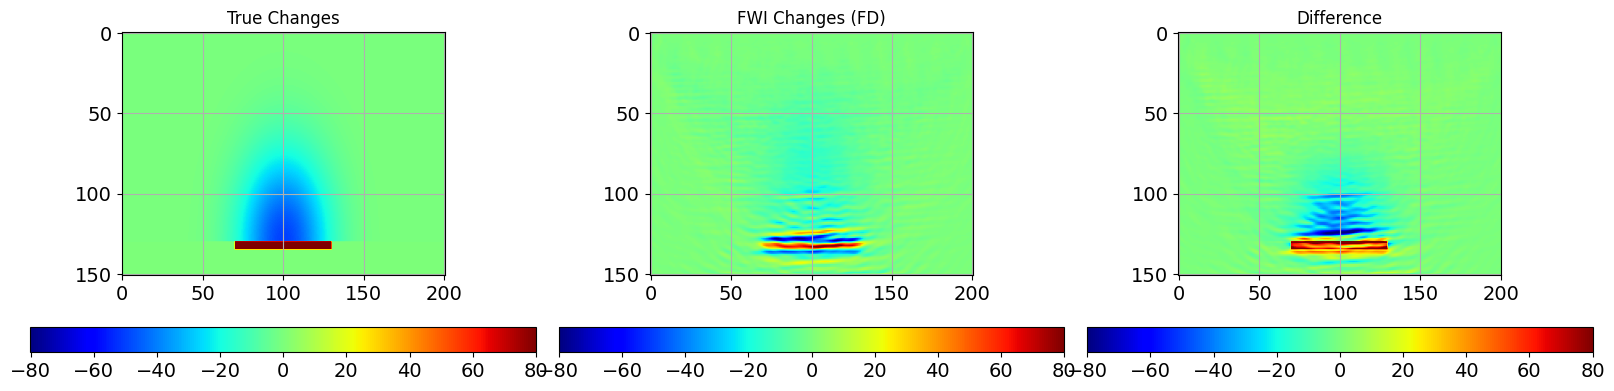

In [49]:
# Plotting
fig = plt.figure(figsize=(16, 4))

shapes = (nx,nz)

plt.subplot(1, 3, 1)
plt.imshow(vp_ml - vp_bl, vmin=-80, vmax=80, cmap='jet')
plt.grid()
plt.title("True Changes")
plt.colorbar(orientation='horizontal')

plt.subplot(1, 3, 2)
plt.imshow(model_init_fd.get_model('vp') - vp_ml_init , vmin=-80, vmax=+80, cmap='jet')
plt.grid()
plt.title("FWI Changes (FD)")
plt.colorbar(orientation='horizontal')

plt.subplot(1, 3, 3)
plt.imshow(vp_ml - vp_bl - (model_init_fd.get_model('vp') - vp_ml_init), vmin=-80, vmax=+80, cmap='jet')
plt.grid()
plt.title("Difference")
plt.colorbar(orientation='horizontal')

plt.tight_layout()
plt.show()


## FWI with RBF Parameterization

In [50]:
sigma = set_sigma(centers_2d, 1.0)
theta_vp = np.zeros(len(centers_2d))
theta_vs = np.zeros(len(centers_2d))
theta_rho = np.zeros(len(centers_2d))

model_init_rbf = ElasticModelRBF(ox, oz, dx, dz, nx, nz, 
                                  centers = centers_2d, 
                                  sigma = sigma,
                                  theta_vp = theta_vp, 
                                  theta_vs = theta_vs, 
                                  theta_rho = theta_rho, 
                                  update_theta_vp = True,
                                  update_sigma = False,
                                  vp = vp_ml_init, 
                                  vs = vs, 
                                  rho = rho, 
                                  vp_bound = [1400, 5000],
                                  free_surface=False, nabc=20,
                                  mask = grad_mask)

Precomputing the RBF ...


In [51]:
model_init_rbf

Elastic model with parameters ['vp', 'vs', 'rho']:
  Model vp  :  1897.21 -  2709.07 m/s   , requires_grad = False, constrain bound: 1400 - 5000
  Model vs  :     0.00 -     0.00 m/s   , requires_grad = False, constrain bound: None - None
  Model rho :  3000.00 -  3000.00 kg/m^3, requires_grad = False, constrain bound: None - None
  Model orig: ox =   0.00, oz =   0.00 m
  Model grid: dx =  10.00, dz =  10.00 m
  Model dims: nx =    201, nz =    151
  Model size: 91053
  Free surface: False
  Absorbing layers: 20

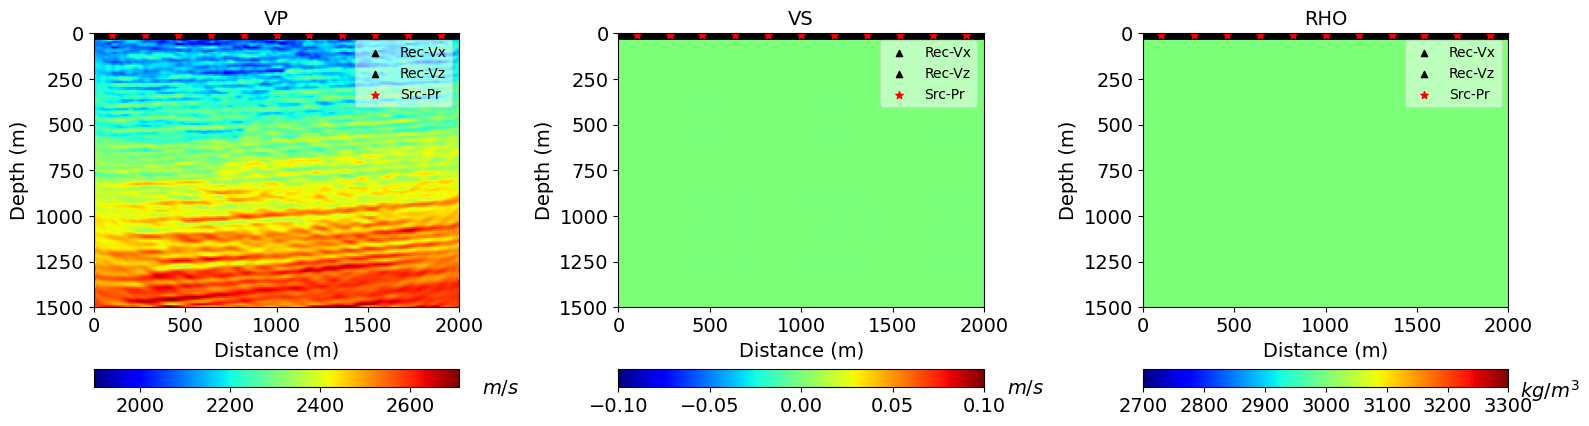

In [52]:
model_init_rbf.plot(survey, orientation='horizontal')

In [53]:
# Setup optimizer
optimizer = torch.optim.LBFGS(model_init_rbf.parameters(), 
              lr = 1.0,
              max_iter = 55,
              tolerance_change = 1e-4, 
              history_size = 5,
              line_search_fn = 'strong_wolfe')

# Setup misfit function
misfit = torch.nn.MSELoss()

# Setup components
weight = {'vx': 1.0, 'vz': 1.0}
# weight = {'pr': 1.0}

In [54]:
fwi = ElasticFWI(F, model_init_rbf, optimizer, misfit, dobs_ml, weight)

In [55]:
fwi(nshot_per_gpu_per_batch = 5, max_iter = 3, grad_scale = 20.0, grad_interval = 4, log_file = 'fwi-acoustic-rbf-SEAM.log')

**********************************************************
            PyTorch l-BFGS Optimizer                
***********************************************************
     Convergence criterion  :   1.00e-04
     Max iteration          :         55
***********************************************************

   Niter           fk                ngrad          max grad
     1       3.553289e+02                1         9.70e-01
     1       3.531737e+02                1         8.37e-01
     1       3.527115e+02                1         7.87e-01
     1       3.425695e+02                1         5.86e-01
     2       3.160466e+02                5         4.82e-01
     3       2.685793e+02                6         3.73e-01
     4       2.425740e+02                7         2.82e-01
     5       2.276538e+02                8         2.72e+00
     6       2.004957e+02                9         8.71e-01
     7       1.920394e+02               10         3.55e-01
     8       1.800774e+0

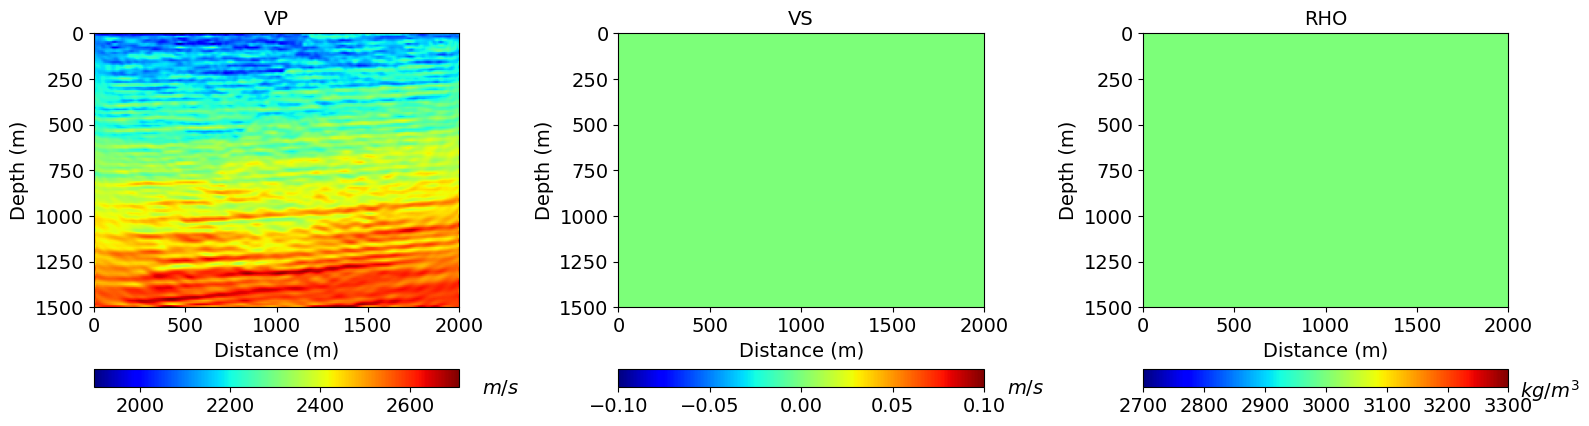

In [56]:
model_init_rbf.plot()

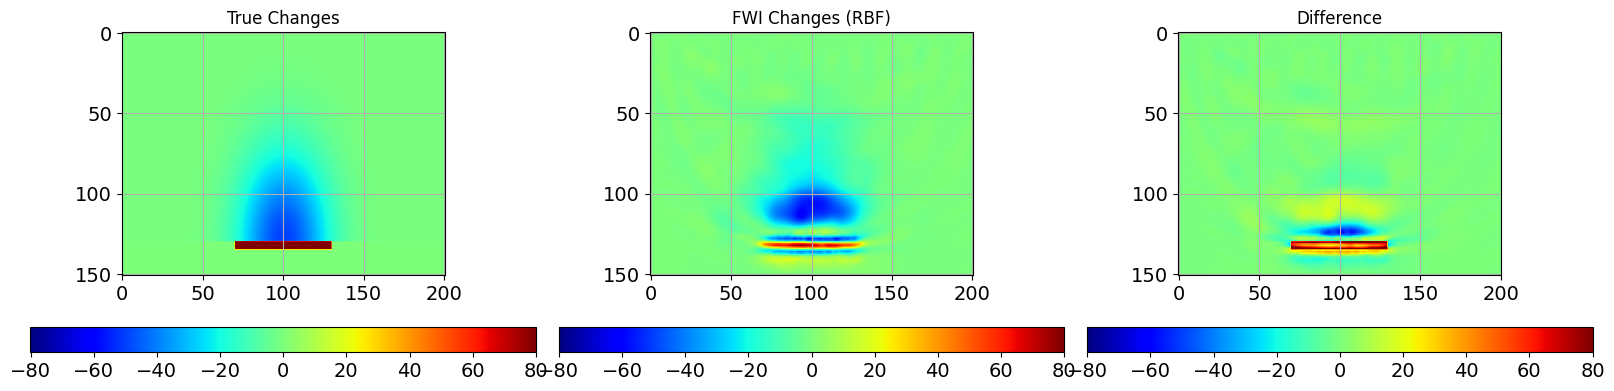

In [57]:
# Plotting
fig = plt.figure(figsize=(16, 4))

shapes = (nx,nz)

plt.subplot(1, 3, 1)
plt.imshow(vp_ml - vp_bl, vmin=-80, vmax=80, cmap='jet')
plt.grid()
plt.title("True Changes")
plt.colorbar(orientation='horizontal')

plt.subplot(1, 3, 2)
plt.imshow(model_init_rbf.get_model('vp') - vp_ml_init , vmin=-80, vmax=+80, cmap='jet')
plt.grid()
plt.title("FWI Changes (RBF)")
plt.colorbar(orientation='horizontal')

plt.subplot(1, 3, 3)
plt.imshow(vp_ml - vp_bl - (model_init_rbf.get_model('vp') - vp_ml_init), vmin=-80, vmax=+80, cmap='jet')
plt.grid()
plt.title("Difference")
plt.colorbar(orientation='horizontal')

plt.tight_layout()
plt.show()


## Compare results

In [58]:
loss_fd  = load_misfit('fwi-acoustic-fd-SEAM.log')
loss_rbf = load_misfit('fwi-acoustic-rbf-SEAM.log')

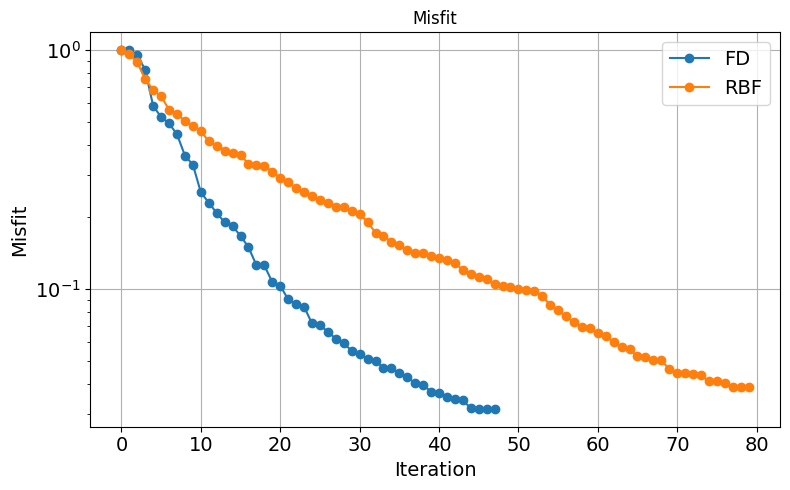

In [59]:
plot_misfit([loss_fd, loss_rbf], label=['FD', 'RBF'])

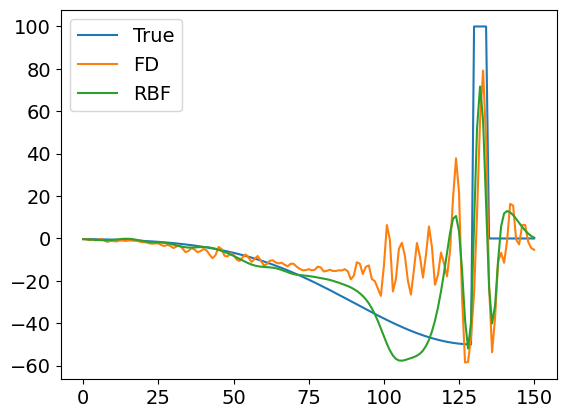

In [60]:
plt.figure()
plt.plot(vp_ml[:, nx//2] - vp_bl[:, nx//2], label='True')
plt.plot(model_init_fd.get_model('vp')[:, nx//2]- vp_ml_init[:, nx//2], label='FD')
plt.plot(model_init_rbf.get_model('vp')[:, nx//2]- vp_ml_init[:, nx//2], label='RBF')
plt.legend()

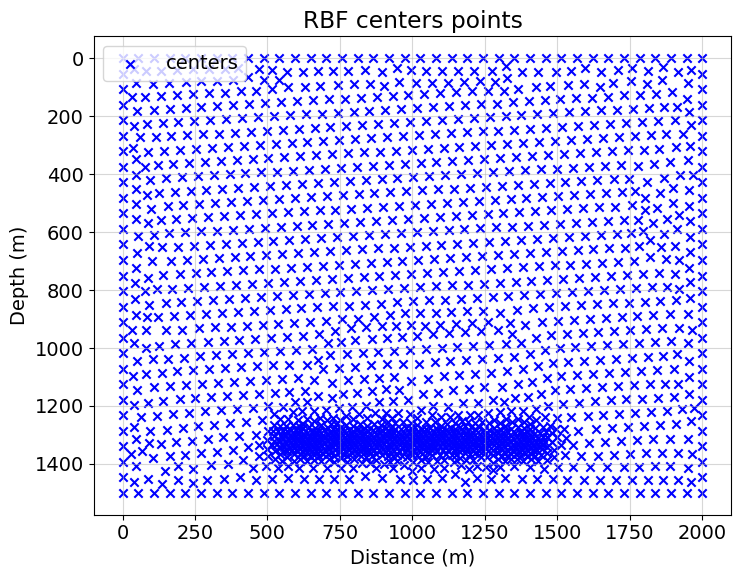

In [61]:
model_init_rbf.plot_center(data_type='centers')

## Plot

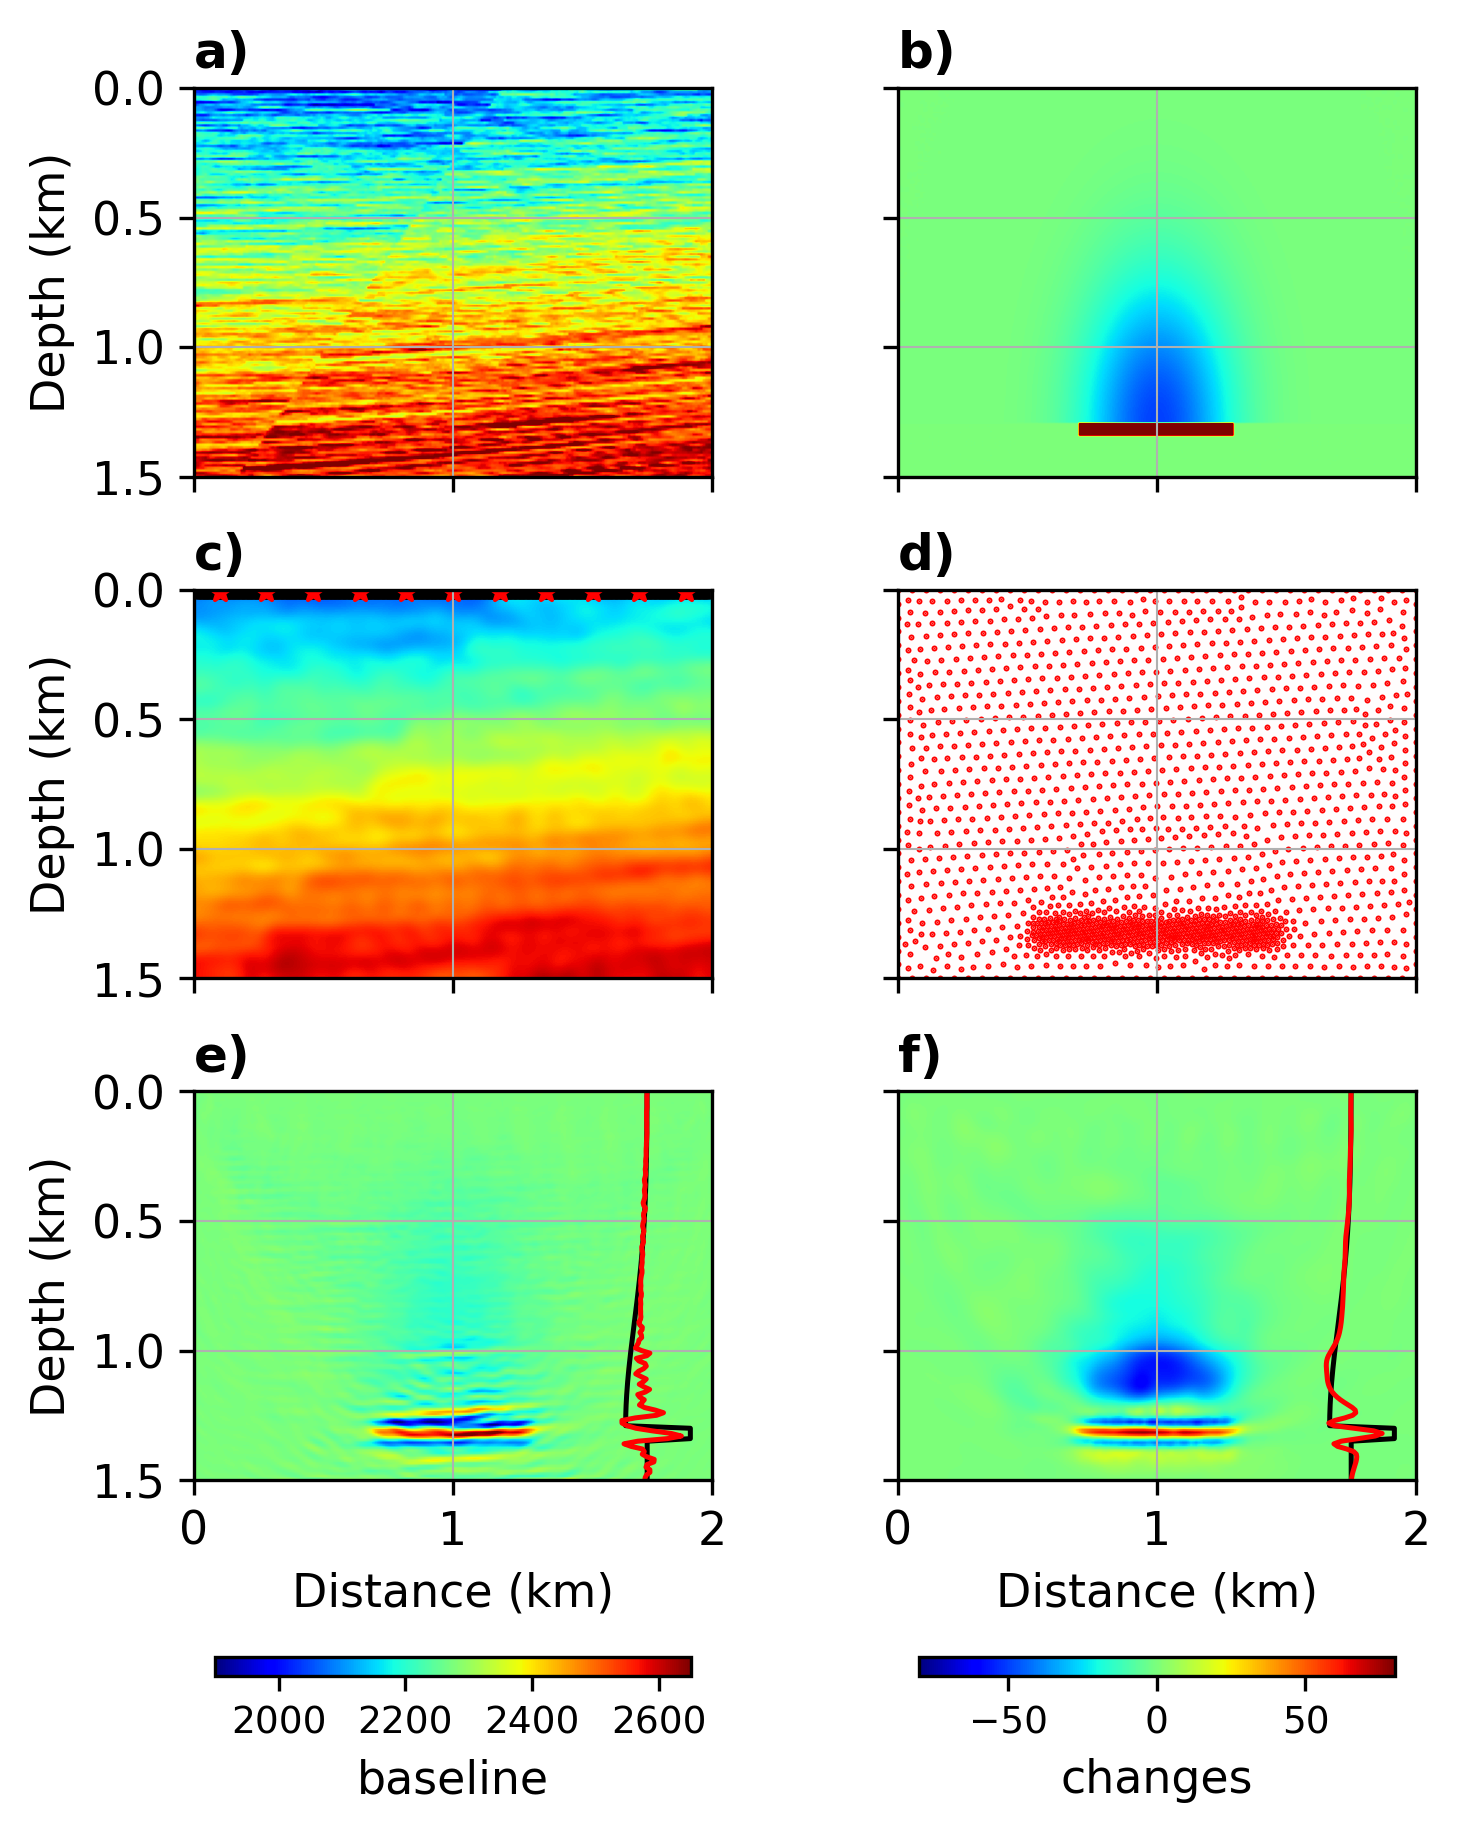

In [62]:
fontsize = 11
plt.rcParams.update({
        "axes.labelsize": fontsize,
        "xtick.labelsize": fontsize,
        "ytick.labelsize": fontsize,
        "legend.fontsize": fontsize,
        "figure.titlesize": fontsize,
})


fig, axs = plt.subplots(3, 2, figsize=(5, 6), dpi=300, constrained_layout=True)

vp_bl = model_bl.get_model('vp')
vp_ml = model_ml.get_model('vp')
vp_init = vp_init
vp_fwi_bl = model_init.get_model('vp')
vp_fwi_fd = model_init_fd.get_model('vp')
vp_fwi_rbf = model_init_rbf.get_model('vp')

aspect=1
extent = [x[0]/1000, x[-1]/1000, z[-1]/1000, z[0]/1000]
cmap_range = [(1900, 2650),(-80, 80),(1900, 2650),(-1, 1),(-80, 80), (-80, 80),  (-80, 80)]
labels = ['a)', 'b)', 'c)',  'd)', 'e)', 'f)']
cmaps = ['jet','jet', 'jet', 'seismic', 'jet', 'jet']

ims = []
for k, model in enumerate([vp_bl, vp_ml - vp_bl, vp_init, vp_init*0, vp_fwi_fd-vp_fwi_bl,  vp_fwi_rbf - vp_fwi_bl]):
    i, j = np.divmod(k, 2)
    im = axs[i][j].imshow(model, extent=extent, cmap=cmaps[k], vmin=cmap_range[k][0], vmax=cmap_range[k][1], aspect=aspect)
    axs[i][j].grid(alpha=1, linewidth=0.5)
    if k == 4:
        axs[i][j].plot((vp_ml[:, nx//2] - vp_bl[:, nx//2])/600  + 1.75, z/1000, linewidth=1.2, color='k')
        axs[i][j].plot((model_init_fd.get_model('vp')[:, nx//2]- vp_ml_init[:, nx//2])/600  + 1.75, z/1000, linewidth=1.2, color='r')
    if k == 5:
        axs[i][j].plot((vp_ml[:, nx//2] - vp_bl[:, nx//2])/600  + 1.75, z/1000, linewidth=1.2, color='k')
        axs[i][j].plot((model_init_rbf.get_model('vp')[:, nx//2]- vp_ml_init[:, nx//2])/600  + 1.75, z/1000, linewidth=1.2, color='r')
    if k==3:
        im = axs[i][j].scatter(centers_2d[:,0]/1000, centers_2d[:,1]/1000,  marker='.', color = 'r', s=0.75)
        axs[i][j].set_xlim([x[0]/1000, x[-1]/1000])
        axs[i][j].set_ylim([z[0]/1000, z[-1]/1000])
        axs[i][j].invert_yaxis()
    ims.append(im)

    if i == 2:
        axs[i][j].set_xlabel("Distance (km)")
    else:
        axs[i][j].set_xticklabels([])
    if  j == 0:
        axs[i][j].set_ylabel("Depth (km)")
    else:
        axs[i][j].set_yticklabels([])

    # plot the survey
    if k ==2:
        src = survey.source.get_loc(type='pr')
        rec_vx = survey.receiver.get_loc(type='vx')
        rec_vz = survey.receiver.get_loc(type='vz')
        axs[i][j].scatter(rec_vx[:, 0]/1000, rec_vx[:, 1]/1000, label='GEO-X', marker='^', s=5, c='k', )
        axs[i][j].scatter(rec_vz[:, 0]/1000, rec_vz[:, 1]/1000, label='GEO-Z', marker='^', s=5, c='k', )
        axs[i][j].scatter(src[:, 0]/1000, src[:, 1]/1000,   label='Source', marker='*', s=20, c='r')

    axs[i][j].text(-0.0, 1.15, labels[k], transform=axs[i][j].transAxes, fontsize=12, va='top', fontweight='bold')

    if k == 4:
        cbar = fig.colorbar(ims[0], ax=axs[i, j], location='bottom', pad=0.1, shrink=0.7, aspect=25, label = 'baseline')
        cbar.ax.tick_params(labelsize=9)
    if k == 5:
        cbar = fig.colorbar(ims[k], ax=axs[i, j], location='bottom', pad=0.1, shrink=0.7, aspect=25, label = 'changes')
        cbar.ax.tick_params(labelsize=9)
        
plt.savefig('FWI-Oil.png', dpi=300, bbox_inches='tight')
plt.show()